**Описание проекта**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

## Часть. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats
import re 
import math as mth

In [2]:
data = pd.read_csv(r'C:\Users\Катерина\Desktop\Проекты\logs_exp.csv', sep='\t')

In [3]:
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


- EventName — название события;

- DeviceIDHash — уникальный идентификатор пользователя;

- EventTimestamp — время события;

- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [4]:
data.columns=['event_name', 'id', 'event_time', 'group' ]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   id          244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [6]:
data

,event_name,id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [7]:
data.describe()

,id,event_time,group
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


In [8]:
data['day_and_time'] = pd.to_datetime(data['event_time'], unit='s')

In [9]:
data['day'] = pd.to_datetime(data['event_time'], unit='s').dt.date

In [10]:
data.isna().sum()

event_name      0
id              0
event_time      0
group           0
day_and_time    0
day             0
dtype: int64

Выбросов нет, пропусков тоже

In [11]:
data.duplicated().sum()

413

In [12]:
data[data.duplicated()==True].head(3)

,event_name,id,event_time,group,day_and_time,day
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
2350,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
3573,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01


In [13]:
data[(data['id']==5613408041324010552) & (data['day_and_time']=='2019-07-30 08:19:44')]

,event_name,id,event_time,group,day_and_time,day
452,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30


Найдено 413 дубликата, полностью совпадают, делаем вывод что нужно удалить их.

In [14]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [15]:
data

,event_name,id,event_time,group,day_and_time,day
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_name    243713 non-null  object        
 1   id            243713 non-null  int64         
 2   event_time    243713 non-null  int64         
 3   group         243713 non-null  int64         
 4   day_and_time  243713 non-null  datetime64[ns]
 5   day           243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


In [17]:
data['day'] = data['day'].astype('datetime64[ns]')

C:\Users\Катерина\AppData\Local\Temp\ipykernel_10412\247273370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['day'].astype('datetime64[ns]')


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_name    243713 non-null  object        
 1   id            243713 non-null  int64         
 2   event_time    243713 non-null  int64         
 3   group         243713 non-null  int64         
 4   day_and_time  243713 non-null  datetime64[ns]
 5   day           243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


In [19]:
data['group'].value_counts()

248    85582
246    80181
247    77950
Name: group, dtype: int64

В процессе мы сделали:
- Замену названий
- Проанализировали данные на пропуски, аномалии, дубликаты (нашли 413 шт и удалили их)
- Добавили стобцы даты и времени, скорректировав их типы

## Часть. Изучите и проверьте данные

In [20]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [21]:
data['event_name'].count()

243713

Всего событий в логе 243713, а уникальных 5 

In [22]:
data['id'].nunique()

7551

всего уникальных пользователей в логе 7551

In [23]:
(data['event_name'].count()/data['id'].nunique()).round(2)

32.28

В среднем 32 события приходится на пользователя

In [24]:
event_by_user = data.groupby('id')['event_name'].count()

In [25]:
event_by_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

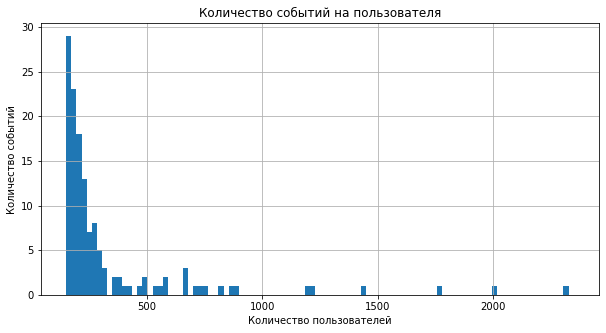

In [26]:
plt.figure(figsize=(10,5))
plt.hist(event_by_user, bins=100, range=(150,2350)) 
plt.xlabel('Количество пользователей')
plt.grid()
plt.ylabel('Количество событий')
plt.title('Количество событий на пользователя');

На граике видим выбросы свыше 1500. Таким образом лучше брать медиану

In [27]:
event_by_user.median()

20.0

В среднем 20 событий приходится на пользователя

In [28]:
data['day'].min()

Timestamp('2019-07-25 00:00:00')

In [29]:
data['day'].max()

Timestamp('2019-08-07 00:00:00')

25 июля начало и 7 августа конец периода данных

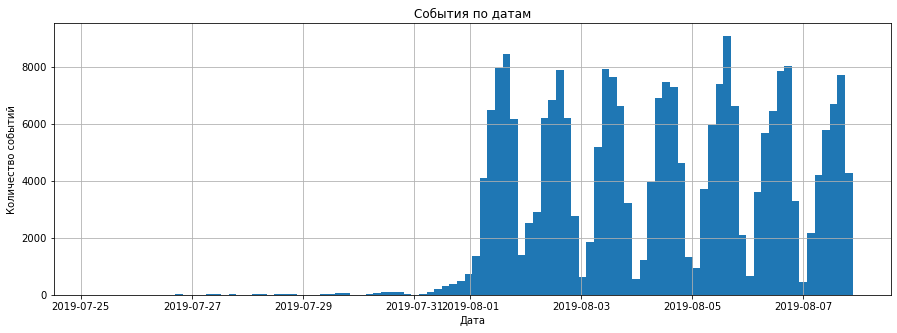

In [30]:
plt.figure(figsize=(15,5))
plt.hist(data['day_and_time'], bins=100) 
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Количество событий')
plt.title('Cобытия по датам')
plt.show()

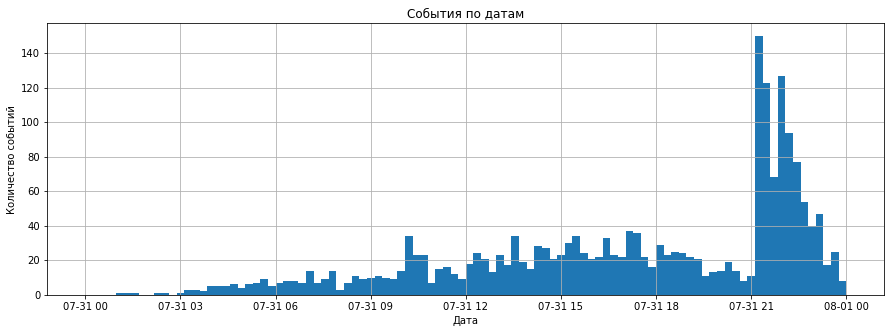

In [31]:
plt.figure(figsize=(15,5))
plt.hist(data['day_and_time'], bins=100, range=('2019-07-31 00:00:00','2019-08-01 00:00:00')) 
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Количество событий')
plt.title('Cобытия по датам')
plt.show()

Прослеживается некий скачек начиная с '2019-07-31 21:00:00', скорее всего «перекос данных» начинается с данного момента. 
Нужно очистить данные до 31 июля.
Таким образом достоверные данные у нас с '2019-07-31 21:00:00' по '2019-08-07 00:00:00'

In [32]:
old_users = data['id'].nunique()

In [33]:
old_event_name = data['event_name'].count()

In [34]:
data = data.loc[data['day_and_time'] > '2019-07-31 21:00:00'].sort_values(by='day_and_time').reset_index(drop=True)

In [35]:
data

,event_name,id,event_time,group,day_and_time,day
0,MainScreenAppear,7701922487875823903,1564606857,247,2019-07-31 21:00:57,2019-07-31
1,MainScreenAppear,2539077412200498909,1564606905,247,2019-07-31 21:01:45,2019-07-31
2,OffersScreenAppear,3286987355161301427,1564606941,248,2019-07-31 21:02:21,2019-07-31
3,OffersScreenAppear,3187166762535343300,1564606943,247,2019-07-31 21:02:23,2019-07-31
4,MainScreenAppear,1118952406011435924,1564607005,248,2019-07-31 21:03:25,2019-07-31
...,...,...,...,...,...,...
241719,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
241720,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
241721,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
241722,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [36]:
new_users = data['id'].nunique()
new_users

7538

In [37]:
old_users

7551

In [38]:
old_users - new_users

13

In [39]:
round((old_users - new_users)/old_users*100,2)

0.17

In [40]:
new_event_name = data['event_name'].count()
new_event_name

241724

In [41]:
old_event_name

243713

In [42]:
old_event_name - new_event_name

1989

In [43]:
round((old_event_name - new_event_name)/old_event_name*100,2)

0.82

Было пользователей 7551 - cтало 7538. Потеря данных составила  0.17%

Было событий 243713 - cтало 241724. Потеря данных составила 0.82%

In [44]:
data['group'].value_counts()

248    84875
246    79556
247    77293
Name: group, dtype: int64

In [45]:
data.groupby('group')['id'].nunique()

group
246    2484
247    2517
248    2537
Name: id, dtype: int64

Пользователей в каждой группе приблизительно по 2,5 тысячи

Количество событий, происходивших в июле не значимо по сравнению с августом. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные», таким образом нашли этот период. В ходе отрезания данных было отсечено 0,17% пользователей и 0,82% событий что не существенно. Среднее количество событий пользователя равно 32, ноесть выбросы берем медиану равную 20. Количество пользователей в каждой группе приблизительно стало по 2,5 тысячи, а событий по 80 тысяч. 

## Часть. Изучите воронку событий

### Cобытия которые есть в логах, как часто они встречаются

In [46]:
data['event_name'].value_counts()

MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Tutorial                     1010
Name: event_name, dtype: int64

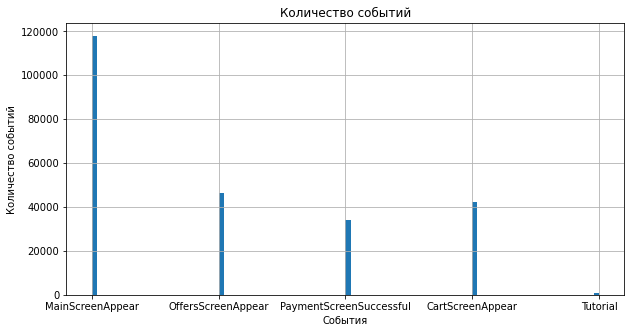

In [47]:
plt.figure(figsize=(10,5))
plt.hist(data['event_name'], bins=100) 
plt.xlabel('События')
plt.grid()
plt.ylabel('Количество событий')
plt.title('Количество событий')
plt.show()

Появление главного экрана самое частое событие среди всех, примерно 12 тыс. раз

С небольшим разрывом встречается 3 события: появление предложений, проведение платежа, появление корзины.


### Cколько пользователей совершали каждое из этих событий c подсчетом доли пользователей, которые хоть раз совершали событие.

In [48]:
id_event = data.groupby('event_name').agg({'event_name':'count', 'id':'nunique'}).sort_values(by='id', ascending=False)
id_event.columns = ['count',  'id']
id_event.reset_index()

,event_name,count,id
0,MainScreenAppear,117889,7423
1,OffersScreenAppear,46531,4597
2,CartScreenAppear,42343,3736
3,PaymentScreenSuccessful,33951,3540
4,Tutorial,1010,843


In [49]:
id_event

,count,id
event_name,,
MainScreenAppear,117889,7423
OffersScreenAppear,46531,4597
CartScreenAppear,42343,3736
PaymentScreenSuccessful,33951,3540
Tutorial,1010,843


In [50]:
id_event['id_prst'] = (id_event['id'] / data['id'].nunique() * 100).round(2)


### Предположите, в каком порядке происходят события.

In [51]:
id_event

,count,id,id_prst
event_name,,,
MainScreenAppear,117889,7423,98.47
OffersScreenAppear,46531,4597,60.98
CartScreenAppear,42343,3736,49.56
PaymentScreenSuccessful,33951,3540,46.96
Tutorial,1010,843,11.18


Судя по количеству событий, пользователь сначало заходит на стартовый экран, видит окно с предложениями(которые его заинтересовывают), оформляем товары в корзину и далее совершает платеж.
Картина вырисовывается достаточно складно.
Так же есть инструкции для тех кто не разобрался.

In [52]:
(id_event.reset_index().loc[4,'count'] / data['event_name'].count()).round(4)

0.0042

Не все события попадают в воронку, попадает все кроме руководства пользователя. Tutorial составляет всего 0.42%, что не значительно

In [53]:
data = data.loc[data['event_name'] != 'Tutorial'].sort_values(by='day_and_time').reset_index(drop=True)
data

,event_name,id,event_time,group,day_and_time,day
0,MainScreenAppear,7701922487875823903,1564606857,247,2019-07-31 21:00:57,2019-07-31
1,MainScreenAppear,2539077412200498909,1564606905,247,2019-07-31 21:01:45,2019-07-31
2,OffersScreenAppear,3286987355161301427,1564606941,248,2019-07-31 21:02:21,2019-07-31
3,OffersScreenAppear,3187166762535343300,1564606943,247,2019-07-31 21:02:23,2019-07-31
4,MainScreenAppear,1118952406011435924,1564607005,248,2019-07-31 21:03:25,2019-07-31
...,...,...,...,...,...,...
240709,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
240710,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
240711,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
240712,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


### Доля пользователей проходящих на следующий шаг воронки 

Добавим в таблицу id_event расчетные данные : доля пользователей перешедших с предыдущего этапа и доля пользователей с первоначального этапа

In [54]:
id_event = data.groupby('event_name').agg({'event_name':'count', 'id':'nunique'}).sort_values(by='id', ascending=False)
id_event.columns = ['count',  'id']
id_event.reset_index()
id_event['id_prst'] = (id_event['id'] / data['id'].nunique() * 100).round(2)

In [55]:
id_event.reset_index()

,event_name,count,id,id_prst
0,MainScreenAppear,117889,7423,98.53
1,OffersScreenAppear,46531,4597,61.02
2,CartScreenAppear,42343,3736,49.59
3,PaymentScreenSuccessful,33951,3540,46.99


In [56]:
prev_users = id_event.reset_index().loc[0,'id']
start_users = prev_users

In [57]:
for i in id_event.index:
    id_event.loc[i,'user_last'] = (id_event.loc[i,'id'] / prev_users * 100).round(1)
    id_event.loc[i,'user_start'] = (id_event.loc[i,'id'] / start_users * 100).round(1)
    prev_users = id_event.loc[i,'id']
id_event   

,count,id,id_prst,user_last,user_start
event_name,,,,,
MainScreenAppear,117889,7423,98.53,100.0,100.0
OffersScreenAppear,46531,4597,61.02,61.9,61.9
CartScreenAppear,42343,3736,49.59,81.3,50.3
PaymentScreenSuccessful,33951,3540,46.99,94.8,47.7


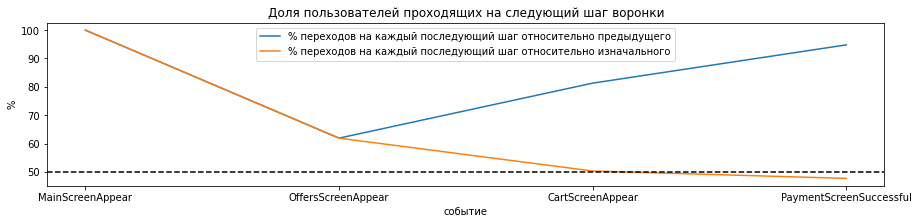

In [58]:
# Задаем размеры графиков
plt.figure(figsize=(15, 3))

plt.plot(id_event['user_last'], label='% переходов на каждый последующий шаг относительно предыдущего')
plt.plot(id_event['user_start'], label='% переходов на каждый последующий шаг относительно изначального')
plt.legend() 

#  Добавляем подписи к осям:
plt.title('Доля пользователей проходящих на следующий шаг воронки')
plt.xlabel('событие')
plt.ylabel('%')

# добавляем ось X
plt.axhline(y=50, color='black', linestyle='--')


plt.show()

По воронке мы видим что у тех кто % переходов на каждый последующий шаг относительно изначального выглядит обычно - тенденция к нисхождению.

% переходов на каждый последующий шаг относительно предыдущего - выглядит странно, после переходов на страницу предложений вырастает количество переходов в корзину и далее увеличение оплат, такого не может быть. Надо найти причину аномалии.

### Момент потери пользователей

In [59]:
id_event['diff_user_last'] = 100 - id_event['user_last']
id_event['diff_user_start'] = 100 - id_event['user_start']
id_event

,count,id,id_prst,user_last,user_start,diff_user_last,diff_user_start
event_name,,,,,,,
MainScreenAppear,117889,7423,98.53,100.0,100.0,0.0,0.0
OffersScreenAppear,46531,4597,61.02,61.9,61.9,38.1,38.1
CartScreenAppear,42343,3736,49.59,81.3,50.3,18.7,49.7
PaymentScreenSuccessful,33951,3540,46.99,94.8,47.7,5.2,52.3


По % переходов на каждый последующий шаг относительно предыдущего: больше всего теряется пользователей на моменте перехода с главной страницы на страницу предложений (38% пользователей). Значит что-то на главной странице отпугивает потенциальных покупателей, возможно страница долго грузится, или возникает ошибка.

По % переходов на каждый последующий шаг относительно изначального: на моменте оплаты. Возможно есть техническая причина?

### Доля пользователей доходящая от первого события до оплаты

In [60]:
id_event.reset_index().loc[3,'user_start'].round(0)

48.0

Всего до оплаты доходит 48% пользователей, процент достаточно хороший.

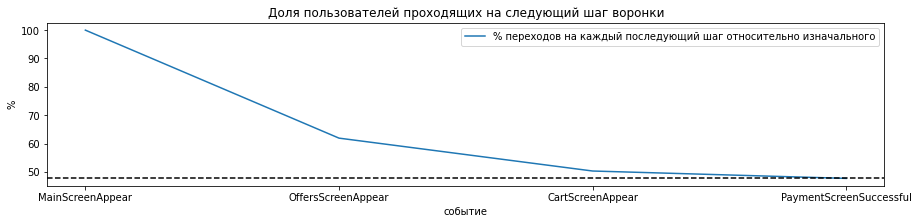

In [61]:
# Задаем размеры графиков
plt.figure(figsize=(15, 3))

plt.plot(id_event['user_start'], label='% переходов на каждый последующий шаг относительно изначального')
plt.legend() 

#  Добавляем подписи к осям:
plt.title('Доля пользователей проходящих на следующий шаг воронки')
plt.xlabel('событие')
plt.ylabel('%')

# добавляем ось X
plt.axhline(y=47.7, color='black', linestyle='--')


plt.show()

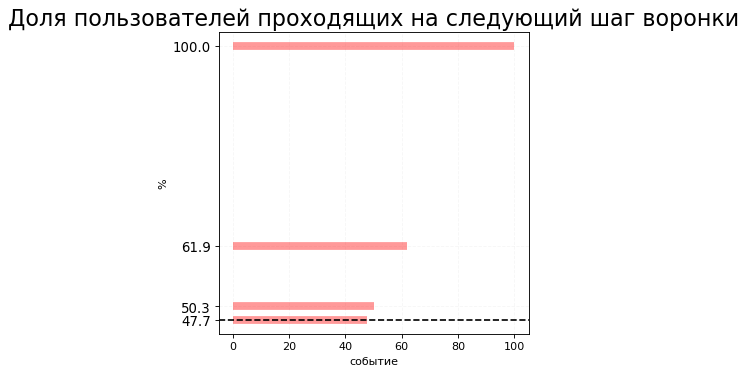

In [62]:
# Draw plot
plt.figure(figsize=(5,5), dpi= 80)
plt.hlines(y=id_event['user_start'], xmin=0, xmax=id_event['user_start'], color='red', alpha=0.4, linewidth=7)

# добавляем ось X
plt.axhline(y=47.7, color='black', linestyle='--')

# Decorations
plt.gca().set(ylabel='%', xlabel='событие')
plt.yticks(id_event['user_start'], fontsize=12)
plt.title('Доля пользователей проходящих на следующий шаг воронки', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.10)
 
plt.show()

**Итоги**

Воронка :
Зашли на сайт на главный экран --- Поиск товара на экране предложений --- Добавили това в корзину--- Совершение платежа
И отдельно выделяем - Руководство пользователя, изучение инструкции

На второй шаг воронки приходится 62% пользователя, 38% не переходят далее. В этом есть проблема и здесь необходимо разработчикам найти причину почему так происходит;

Событие Tutorial можно не включать в анализ, т.к. оно не влечет смысловой нагрузки;

Пройдя по воронке, до экрана оплаты доходят практически 50% пользователей, то есть те кто становиться покупателями.

## Результаты эксперимента

### Состав групп

In [63]:
data['group'][data['group'] == 246].count()

79239

In [64]:
data_246 = data[data['group'] == 246]

In [65]:
data['group'][data['group'] == 247].count()

76953

In [66]:
data_247 = data[data['group'] == 247]

In [67]:
data['group'][data['group'] == 248].count()

84522

In [68]:
data_248 = data[data['group'] == 248]

Ниже приведем данные о количестве событий

246 — контрольная группа количество --- 79 556

247 — контрольная группа количество --- 77 293

248 — экспериментальная количество --- 84 875

Ниже посчитаем количество пользователей по группам

In [69]:
userrrs = data.pivot_table(
    index='group',  
    values='id',
    aggfunc='nunique').reset_index()
userrrs

,group,id
0,246,2483
1,247,2516
2,248,2535


In [70]:
userrrs_A = userrrs.reset_index().loc[0,'id']
userrrs_A

2483

In [71]:
userrrs_A1 = userrrs.reset_index().loc[1,'id']
userrrs_A1

2516

In [72]:
userrrs_B = userrrs.reset_index().loc[2,'id']
userrrs_B

2535

Разбивка на группы достаточно равномерна

### Cтатистическая  разница между выборками 246 и 247

In [73]:
data

,event_name,id,event_time,group,day_and_time,day
0,MainScreenAppear,7701922487875823903,1564606857,247,2019-07-31 21:00:57,2019-07-31
1,MainScreenAppear,2539077412200498909,1564606905,247,2019-07-31 21:01:45,2019-07-31
2,OffersScreenAppear,3286987355161301427,1564606941,248,2019-07-31 21:02:21,2019-07-31
3,OffersScreenAppear,3187166762535343300,1564606943,247,2019-07-31 21:02:23,2019-07-31
4,MainScreenAppear,1118952406011435924,1564607005,248,2019-07-31 21:03:25,2019-07-31
...,...,...,...,...,...,...
240709,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
240710,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
240711,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
240712,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


### Статистическая достоверность событий

In [74]:
group_test = data[data['event_name']!='Tutorial'].pivot_table(
    index='event_name', 
    columns='group', 
    values='id',
    aggfunc='nunique').reset_index()
group_test.columns = ['event_name', 'A', 'A1', 'B']
group_test

,event_name,A,A1,B
0,CartScreenAppear,1266,1239,1231
1,MainScreenAppear,2450,2479,2494
2,OffersScreenAppear,1542,1524,1531
3,PaymentScreenSuccessful,1200,1158,1182


In [75]:
group_test['A+A1'] = group_test['A'] + group_test['A1']
group_test['all'] = group_test['A+A1'] + group_test['B']

group_test['%_A'] = (group_test['A'] / userrrs_A * 100).round(2)
group_test['%_A1'] = (group_test['A1'] / userrrs_A1 * 100).round(2)
group_test['%_B'] = (group_test['B'] / userrrs_B * 100).round(2)
group_test['%_A+A1'] = ((group_test['A'] + group_test['A1']) / \
                                  (userrrs_A + userrrs_A1) * 100).round(2)
group_test

,event_name,A,A1,B,A+A1,all,%_A,%_A1,%_B,%_A+A1
0,CartScreenAppear,1266,1239,1231,2505,3736,50.99,49.24,48.56,50.11
1,MainScreenAppear,2450,2479,2494,4929,7423,98.67,98.53,98.38,98.60
2,OffersScreenAppear,1542,1524,1531,3066,4597,62.10,60.57,60.39,61.33
3,PaymentScreenSuccessful,1200,1158,1182,2358,3540,48.33,46.03,46.63,47.17


In [76]:
data['event_name'].value_counts()

MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Name: event_name, dtype: int64

Cамое популярное событие -- переход на главный экран.
Число пользователей, совершивших это событие в каждой из контрольных групп:
 - 4929 всего, а именно в A = 2450, A1 = 2479, B =2494

Доля пользователей, совершивших это событие:
 - A = 98.63 %, A1 = 98.49 %, B = 98.31 %
 

Для проведения тестов для удобстав напишем функцию 'group_match'

In [77]:
def group_match(gr):
    if gr==246:
        return 'A'
    elif gr==247:
        return 'A1'
    elif gr==248:
        return 'B'
    else:
        return 'UnknownGroup'

data1 = data
data1['group'] = data1['group'].apply(group_match)
data1

,event_name,id,event_time,group,day_and_time,day
0,MainScreenAppear,7701922487875823903,1564606857,A1,2019-07-31 21:00:57,2019-07-31
1,MainScreenAppear,2539077412200498909,1564606905,A1,2019-07-31 21:01:45,2019-07-31
2,OffersScreenAppear,3286987355161301427,1564606941,B,2019-07-31 21:02:21,2019-07-31
3,OffersScreenAppear,3187166762535343300,1564606943,A1,2019-07-31 21:02:23,2019-07-31
4,MainScreenAppear,1118952406011435924,1564607005,B,2019-07-31 21:03:25,2019-07-31
...,...,...,...,...,...,...
240709,MainScreenAppear,4599628364049201812,1565212345,A1,2019-08-07 21:12:25,2019-08-07
240710,MainScreenAppear,5849806612437486590,1565212439,A,2019-08-07 21:13:59,2019-08-07
240711,MainScreenAppear,5746969938801999050,1565212483,A,2019-08-07 21:14:43,2019-08-07
240712,MainScreenAppear,5746969938801999050,1565212498,A,2019-08-07 21:14:58,2019-08-07


In [78]:
users = data.groupby('group')['id'].nunique()
users['A+A1'] = users['A'] + users['A1']
users 

group
A       2483
A1      2516
B       2535
A+A1    4999
Name: id, dtype: int64

**Нулевая гипотеза** --- изменение шрифта не повлияет на поведение пользователей 

**Альтернативная гипотеза** --- изменение шрифта повлияет на поведение пользователей 

**Нулевая гипотеза** ---  между долями нет значимой разницы 

**Альтернативная гипотеза** ---  между долями есть значимая разница 

In [79]:
def stat_dost_test(group, group1, alpha):
    
    for i in group_test.index:
        
        # пропорция успехов в группе:
        p1 = group_test[group][i] / users[group]
        p2 = group_test[group1][i] / users[group1]
        p_combined = ((group_test[group][i] + group_test[group1][i]) / 
                      (users[group] + users[group1]))
        
        
        # разница пропорций
        difference = p1 - p2
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users[group] + 1/users[group1]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = stats.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        display('{} p-значение: {}'.format(group_test['event_name'][i], p_value))
        if (p_value < alpha):
            display("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            display("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        display('.................................................................................')
        
stat_dost_test('A', 'A1', 0.01)

'CartScreenAppear p-значение: 0.21811883651016095'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'MainScreenAppear p-значение: 0.6702082653142836'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'OffersScreenAppear p-значение: 0.2667347868697105'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'PaymentScreenSuccessful p-значение: 0.10288527362638322'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

Делаем точность A/A1-теста в 1% — так как группы A/A1 должны быть равнозначными. 
По результатам тестирования для всех событий разница не оказалось значимой, группы считаем контрольными.

### Сравнение других групп

In [80]:
stat_dost_test('A', 'B', 0.01)

'CartScreenAppear p-значение: 0.08564271892834707'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'MainScreenAppear p-значение: 0.396910049618151'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'OffersScreenAppear p-значение: 0.21442476639710506'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'PaymentScreenSuccessful p-значение: 0.22753674585530037'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

In [81]:
stat_dost_test('A1', 'B', 0.01)

'CartScreenAppear p-значение: 0.6264599792848009'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'MainScreenAppear p-значение: 0.6723167704766229'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'OffersScreenAppear p-значение: 0.8971376549155397'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'PaymentScreenSuccessful p-значение: 0.6680367850275775'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

In [82]:
stat_dost_test('A+A1', 'B', 0.01)

'CartScreenAppear p-значение: 0.20361356481451098'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'MainScreenAppear p-значение: 0.4599468774918498'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'OffersScreenAppear p-значение: 0.4303431159342346'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'PaymentScreenSuccessful p-значение: 0.6559128929243401'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

**Проведя выше анализ A/A, A/B, A1/B можно сделать вывод что значимой разницы между группами нет**

### Меняем на alpha = 0.05

In [83]:
stat_dost_test('A', 'A1', 0.05)

'CartScreenAppear p-значение: 0.21811883651016095'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'MainScreenAppear p-значение: 0.6702082653142836'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'OffersScreenAppear p-значение: 0.2667347868697105'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'PaymentScreenSuccessful p-значение: 0.10288527362638322'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

In [84]:
stat_dost_test('A', 'B', 0.05)

'CartScreenAppear p-значение: 0.08564271892834707'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'MainScreenAppear p-значение: 0.396910049618151'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'OffersScreenAppear p-значение: 0.21442476639710506'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'PaymentScreenSuccessful p-значение: 0.22753674585530037'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

In [85]:
stat_dost_test('A1', 'B', 0.05)

'CartScreenAppear p-значение: 0.6264599792848009'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'MainScreenAppear p-значение: 0.6723167704766229'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'OffersScreenAppear p-значение: 0.8971376549155397'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'PaymentScreenSuccessful p-значение: 0.6680367850275775'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

In [86]:
stat_dost_test('A+A1', 'B', 0.05)

'CartScreenAppear p-значение: 0.20361356481451098'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'MainScreenAppear p-значение: 0.4599468774918498'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'OffersScreenAppear p-значение: 0.4303431159342346'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

'PaymentScreenSuccessful p-значение: 0.6559128929243401'

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

'.................................................................................'

Ничего не поменялось, разницы в группах нет

## Итоги

- В ходе работы были подготовлены и очищены данные до адекватного состояния.
- Изначальные данные были с 25 июля по 7 августа, сделав отсечку достоверных данных получили временые рамки: с 31 июля 21:00 до 7 августа.
- Среднее количество событий на пользователя равняется 20.
- Всего уникальных пользователей в логе 7551.
- Появление главного экрана самое частое событие среди всех, примерно 12 тыс. раз.
- С небольшим разрывом встречается 3 события: появление предложений, проведение платежа, появление корзины.
- ВОРОНКА: Зашли на сайт на главный экран --- Поиск товара на экране предложений --- Добавили товар в корзину-- Совершение платежа. И отдельно выделяем - Руководство пользователя, изучение инструкции.
- На второй шаг воронки приходится 62% пользователя, 38% не переходят далее. В этом есть проблема и здесь необходимо разработчикам найти причину почему так происходит.
- Событие Tutorial можно не включать в анализ, т.к. оно не влечет смысловой нагрузки;
- Пройдя по воронке, до экрана оплаты доходят практически 50% пользователей, то есть те кто становиться покупателями.
- По % переходов на каждый последующий шаг относительно предыдущего: больше всего теряется пользователей на моменте перехода с главной страницы на страницу предложений (38% пользователей). Значит что-то на главной странице отпугивает потенциальных покупателей, возможно страница долго грузится, или возникает ошибка.
- По % переходов на каждый последующий шаг относительно изначального: на моменте оплаты. Возможно есть техническая причина?
- 246 (А)— контрольная группа количество --- 79 556
- 247 (А1)— контрольная группа количество --- 77 293
- 248 (В)— экспериментальная количество --- 84 875
- Cамое популярное событие -- переход на главный экран.
- Число пользователей, совершивших переход на главный экран в каждой из контрольных групп:  - 4929 всего, а именно в A = 2450, A1 = 2479, B =2494
- Доля пользователей, совершивших переход на главный экран:  - A = 98.63 %, A1 = 98.49 %, B = 98.31 %

Тесты:
Было проведено 16 экспериментов:
- A/A1 - 8 эксперемента / статистическая значимость - 1% и 5%
- A/B - 8 эксперемента  / статистическая значимость  - 1% и 5%
- A1/B - 8 эксперемента / статистическая значимость  - 1% и 5%
- A+A1/B - 8 эксперемента / статистическая значимость - 1% и 5%

- Проведя тест на статистическую достоверность можно сказать по результатам тестирования для всех событий разница не оказалось значимой, группы считаем контрольными. За основу брали чувствительность в 1% и 5%, группы анализа А/А1, A/B, A1/B.

**По итогам:**
На поведение пользователей изменение шрифта сильного не повлияло. Тестирование можно назвать успешным.